# Predict whether the movie is going to be nominated or win an award
## Data source: https://www.kaggle.com/orgesleka/imdbmovies
## 1. Load important libraries

In [1]:
from __future__ import print_function
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import itertools
import xgboost

from IPython.display import Markdown, display
%matplotlib inline

sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.preprocessing import StandardScaler

## 2. Read in the data and check missingness

In [2]:
user_info_db = pd.read_csv("imdb.csv", na_values='.')
display(user_info_db.head())
display(user_info_db.info())
display(user_info_db.isnull().sum())

,fn,tid,title,wordsInTitle,url,imdbRating,ratingCount,duration,year,type,...,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
0,titles01/tt0012349,tt0012349,Der Vagabund und das Kind (1921),der vagabund und das kind,http://www.imdb.com/title/tt0012349/,8.4,40550,3240,1921,video.movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,titles01/tt0015864,tt0015864,Goldrausch (1925),goldrausch,http://www.imdb.com/title/tt0015864/,8.3,45319,5700,1925,video.movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,titles01/tt0017136,tt0017136,Metropolis (1927),metropolis,http://www.imdb.com/title/tt0017136/,8.4,81007,9180,1927,video.movie,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,titles01/tt0017925,tt0017925,Der General (1926),der general,http://www.imdb.com/title/tt0017925/,8.3,37521,6420,1926,video.movie,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,titles01/tt0021749,tt0021749,Lichter der Großstadt (1931),lichter der gro stadt,http://www.imdb.com/title/tt0021749/,8.7,70057,5220,1931,video.movie,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15190 entries, 0 to 15189
Data columns (total 44 columns):
fn                  15190 non-null object
tid                 14803 non-null object
title               14769 non-null object
wordsInTitle        14749 non-null object
url                 14761 non-null object
imdbRating          13582 non-null object
ratingCount         13555 non-null object
duration            13730 non-null object
year                14716 non-null object
type                14757 non-null object
nrOfWins            14760 non-null object
nrOfNominations     14761 non-null object
nrOfPhotos          14761 non-null object
nrOfNewsArticles    14761 non-null object
nrOfUserReviews     14761 non-null float64
nrOfGenre           14761 non-null float64
Action              14761 non-null float64
Adult               14761 non-null float64
Adventure           14761 non-null float64
Animation           14761 non-null float64
Biography           14761 non-null float64
Co

None

fn                     0
tid                  387
title                421
wordsInTitle         441
url                  429
imdbRating          1608
ratingCount         1635
duration            1460
year                 474
type                 433
nrOfWins             430
nrOfNominations      429
nrOfPhotos           429
nrOfNewsArticles     429
nrOfUserReviews      429
nrOfGenre            429
Action               429
Adult                429
Adventure            429
Animation            429
Biography            429
Comedy               429
Crime                429
Documentary          429
Drama                429
Family               429
Fantasy              429
FilmNoir             429
GameShow             429
History              429
Horror               429
Music                429
Musical              429
Mystery              429
News                 429
RealityTV            429
Romance              429
SciFi                429
Short                429
Sport                429


Most of the missingness were resulted by three variables including `imdbRating`, `ratingCount`, and `duration`. 

## 2.1 Missing data handling
In this practice, we've decided to obtain a complete dataset by removing the records containing the missing data. Essentially, we can impute the variables like `duration` and `imdbRating`.

In [3]:
df = user_info_db[user_info_db.duration.notnull() & user_info_db.year.notnull() & user_info_db.imdbRating.notnull() & user_info_db.nrOfWins.notnull()]

In [4]:
df.describe()

,nrOfUserReviews,nrOfGenre,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
count,12793.000000,12793.000000,12793.000000,12793.00000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,...,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000,12793.000000
mean,119.201360,4.936137,0.581334,0.06785,0.130696,0.073400,0.048073,0.351442,0.163136,0.074885,...,0.005081,0.005237,0.136012,0.075666,0.034785,0.017275,0.011491,0.098257,0.036739,0.025248
std,247.284245,30.647432,18.990155,4.60722,0.339853,0.260801,0.213929,0.477439,0.369504,0.263216,...,0.071102,0.072182,0.342815,0.264474,0.183241,0.130300,0.106581,0.297673,0.188127,0.156884
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,2.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,122.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4928.000000,1547.000000,1930.000000,488.00000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.2 Remove duplicates

In [5]:
df.drop_duplicates(['tid'])
df = df.drop(['wordsInTitle','url','fn'], axis=1)

## 2.3 Change data variable type

In [6]:
df = df[df.type=="video.movie"]
df[["ratingCount", "duration", "year"]] = df[["ratingCount", "duration", "year"]].astype("int")
df['imdbRating'] = df['imdbRating'].astype("float64")
df.iloc[:,7:] = df.iloc[:,7:].astype("int")
df.drop(['type'], axis=1, inplace=True)

In [7]:
df.describe()

,imdbRating,ratingCount,duration,year,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,nrOfUserReviews,nrOfGenre,...,News,RealityTV,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western
count,10136.000000,1.013600e+04,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,...,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000,10136.000000
mean,6.735438,3.244108e+04,6162.042620,1987.069357,3.466358,4.122534,23.408840,263.617502,139.385063,2.361582,...,0.000197,0.000197,0.163181,0.070837,0.039365,0.019732,0.000296,0.119870,0.042226,0.028019
std,1.069851,7.223499e+04,1960.295803,23.511024,8.540062,9.486967,32.214568,977.154468,264.927769,0.753338,...,0.014046,0.014046,0.369549,0.256564,0.194471,0.139084,0.017202,0.324825,0.201114,0.165035
min,1.300000,5.000000e+00,2.000000,1888.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.200000,1.383000e+03,5400.000000,1972.000000,0.000000,0.000000,3.000000,0.000000,18.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6.900000,6.229000e+03,6000.000000,1996.000000,1.000000,0.000000,12.000000,24.000000,54.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.500000,2.960325e+04,6960.000000,2006.000000,3.000000,4.000000,32.000000,144.000000,147.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,9.500000,1.183395e+06,46200.000000,2014.000000,137.000000,137.000000,407.000000,23660.000000,4928.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2.4 Create the outcome variables, *winner* and *nomination*

In [8]:
df['nomination'] = df.nrOfNominations.ge(1).astype(int)
df['winner'] = df.nrOfWins.ge(1).astype(int)

## 3. Data visualization
Now, we start visualizing this dataset by generating some histograms, scatterplots, and boxplots.

In [9]:
df.head(5)

,tid,title,imdbRating,ratingCount,duration,year,nrOfWins,nrOfNominations,nrOfPhotos,nrOfNewsArticles,...,Romance,SciFi,Short,Sport,TalkShow,Thriller,War,Western,nomination,winner
0,tt0012349,Der Vagabund und das Kind (1921),8.4,40550,3240,1921,1,0,19,96,...,0,0,0,0,0,0,0,0,0,1
1,tt0015864,Goldrausch (1925),8.3,45319,5700,1925,2,1,35,110,...,0,0,0,0,0,0,0,0,1,1
2,tt0017136,Metropolis (1927),8.4,81007,9180,1927,3,4,67,428,...,0,1,0,0,0,0,0,0,1,1
3,tt0017925,Der General (1926),8.3,37521,6420,1926,1,1,53,123,...,0,0,0,0,0,0,0,0,1,1
4,tt0021749,Lichter der Großstadt (1931),8.7,70057,5220,1931,2,0,38,187,...,1,0,0,0,0,0,0,0,0,1


## 3.1 Histograms

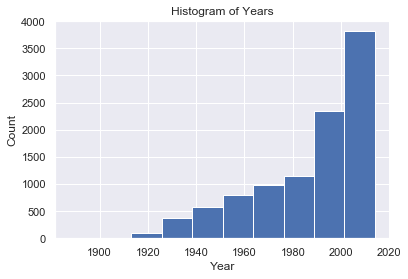

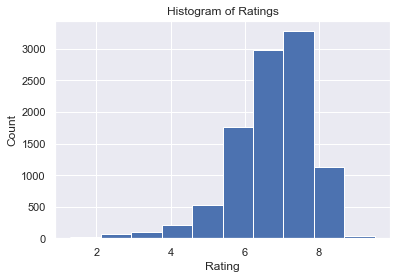

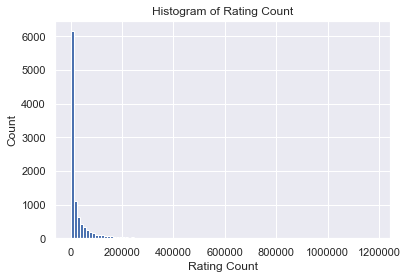

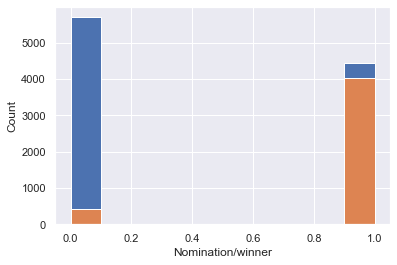

In [10]:
df['year'].hist()
plt.title('Histogram of Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()
plt.close()

df['imdbRating'].hist()
plt.title('Histogram of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()
plt.close()
    
df['ratingCount'].hist(bins=100)
plt.title('Histogram of Rating Count')
plt.xlabel('Rating Count')
plt.ylabel('Count')
plt.show()
plt.close()

plot_hist1 = df[(df.nomination) == 1].copy()
plot_hist0 = df[(df.nomination) == 0].copy()
plt.hist(df.nomination)
plot_hist1['goodRating'] = plot_hist1['imdbRating'].ge(6).astype(int)
plt.hist(plot_hist1.goodRating)
plt.xlabel('Nomination/winner')
plt.ylabel('Count')
plt.show()
plt.close()

## 3.2 Scattterplot

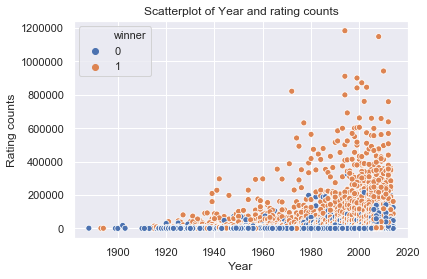

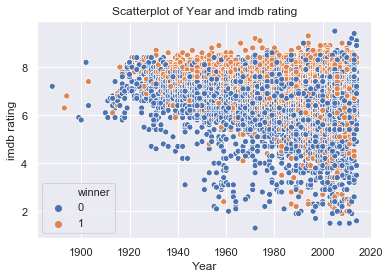

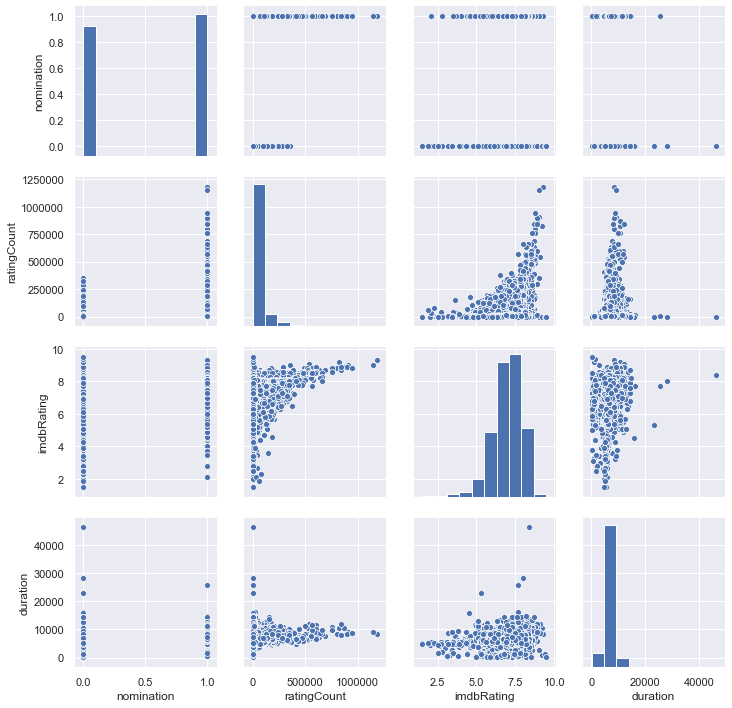

In [11]:
sns.scatterplot("year", "ratingCount", "winner",data=df)
plt.title('Scatterplot of Year and rating counts')
plt.xlabel('Year')
plt.ylabel('Rating counts')
plt.show()
plt.close()

sns.scatterplot("year","imdbRating",'winner',data=df)
plt.title('Scatterplot of Year and imdb rating')
plt.xlabel('Year')
plt.ylabel('imdb rating')
plt.show()
plt.close()

sns.pairplot(df[['nomination', 'ratingCount','imdbRating', 'duration']].head(5000))
plt.show()
plt.close()

## 3.3 Boxplot

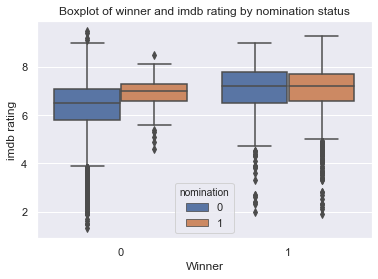

In [12]:
sns.boxplot(x="winner", y="imdbRating", hue="nomination", data=df)
plt.title('Boxplot of winner and imdb rating by nomination status')
plt.xlabel('Winner')
plt.ylabel('imdb rating')
plt.show()
plt.close()

In [13]:
display(df.nomination.value_counts())
display(df.winner.value_counts())

0    5696
1    4440
Name: nomination, dtype: int64

1    5154
0    4982
Name: winner, dtype: int64

## 4. Feature Selection and Feature Engineering
<a id='feature selection'></a>

**Feature Selection Box:** The toggle switches for various features and settings are below. A value of 0 disables the feature, and a value of 1 enables the feature.

In [14]:
# Selection of different features

feature_winner = 0          # Select this feature to make prediction on award winner. 
                            # Disable this feautre to make prediction on nomination winners.

# Normalize features
normalize_flag = 1
          
#Model Selection flags
LR_flag = 1
LS_flag = 1
DT_flag = 1
RF_flag = 1
GB_flag = 1
NN_flag = 1
SVM_flag = 1
XGB_flag = 1

You are going to be graphing the features to help better understand how features might relate to each other. Below is defining the function to be called later after the data has been imported. 

In [15]:
#plot Confusion Matrix function

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    plt.close()


# end Confusion Matrix function


# ROC Curve Plotting function

def plot_roc_curve(fpr,tpr):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b',
             label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([-0.1, 1.2])
    plt.ylim([-0.1, 1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.close()

#end ROC plotting function


# Precision Recall (PR) function

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.show( )
    plt.close()

#end PR function

# plot ROC curve function

def plot_figure(fpr, tpr, label):
    plt.figure()
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")    
    plt.show()
 

In [16]:
X_train = df.drop(["tid","title","winner","nomination","nrOfWins", "nrOfNominations"], axis=1)
Y_train = df['nomination']

if feature_winner:
    X_train = df.drop(["tid","title","winner","nomination","nrOfWins", "nrOfNominations"], axis=1)
    Y_train = df['winner']
    
if normalize_flag:
    X_train=(StandardScaler().fit_transform(X_train))

Split the dataset into training and test data sets.

## 5. Algorithm Comparison and Selection

In [17]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.25, random_state=0) 

Now you will build models using Logistic Regression, Support Vector Machine (SVM), Random Forest (RF), Decision Tree (DT), Gradient Boosting (GB), Multi-Layer Perceptron (NN), and XGBoost classification schemes. The various scores such as Precision, Recall, ROC, F1, Accuracy are measured. You will also plot the ROC curves for the different models. 

LR Accuracy 0.755722178374112
roc score 0.7468931740152345
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      4277
           1       0.74      0.68      0.71      3325

    accuracy                           0.76      7602
   macro avg       0.75      0.75      0.75      7602
weighted avg       0.75      0.76      0.75      7602

Confusion matrix, without normalization
[[3496  781]
 [1076 2249]]


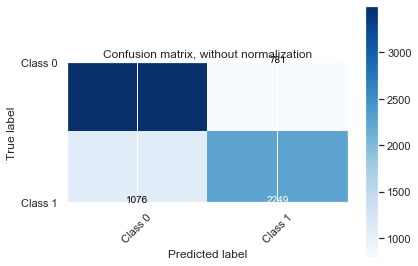

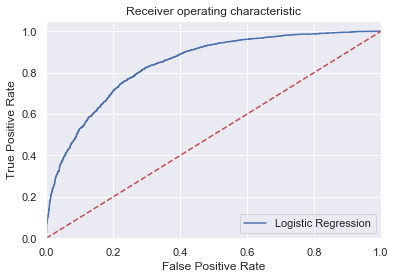

In [18]:
if LR_flag:

    # Logistic Regression Model
    logisticRegr = LogisticRegression(max_iter=1000,solver="lbfgs")
    y_train_pred_LR = cross_val_predict(logisticRegr, x_train, y_train, cv=3, method='predict_proba')[:,1]
    y_train_pred = y_train_pred_LR.round()
    print("LR Accuracy",accuracy_score(y_train, y_train_pred))
    print("roc score", roc_auc_score(y_train, y_train_pred))
    print("Classification Report")
    print("="*50)
    LR_CR = classification_report(y_train, y_train_pred)
    print(classification_report(y_train, y_train_pred))
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute ROC curve and ROC area   
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_LR)
    plot_figure(fpr, tpr, 'Logistic Regression')


SVM Accuracy 0.6935017100762957
roc score 0.6931036264966834
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.70      0.72      4277
           1       0.64      0.69      0.66      3325

    accuracy                           0.69      7602
   macro avg       0.69      0.69      0.69      7602
weighted avg       0.70      0.69      0.69      7602

Confusion matrix, without normalization
[[2978 1299]
 [1031 2294]]


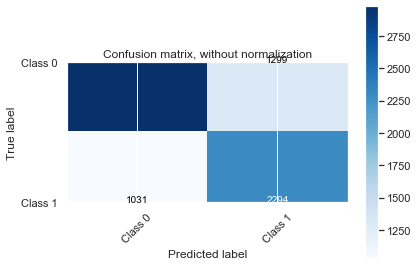

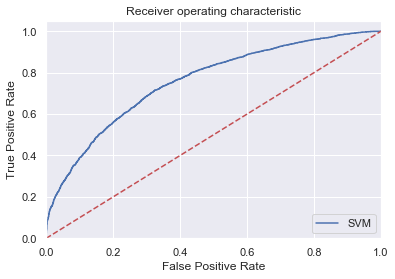

In [19]:
if SVM_flag:
    # SVM Model

    sgd_clf = SGDClassifier(random_state=0, loss="log", max_iter=1000, tol=3 )
    y_train_pred_SVM = cross_val_predict(sgd_clf, x_train, y_train, cv=3, method="predict_proba")[:,1]
    y_train_pred = y_train_pred_SVM.round()
    print("SVM Accuracy",accuracy_score(y_train, y_train_pred))
    print("roc score", roc_auc_score(y_train, y_train_pred))
    SVM_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(SVM_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area 
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_SVM)
    plot_figure(fpr, tpr, "SVM")


DT Accuracy 0.7146803472770323
roc score 0.7103520667462436
Classification Report
              precision    recall  f1-score   support

           0       0.75      0.74      0.75      4277
           1       0.67      0.68      0.67      3325

    accuracy                           0.71      7602
   macro avg       0.71      0.71      0.71      7602
weighted avg       0.71      0.71      0.71      7602

Confusion matrix, without normalization
[[3186 1091]
 [1078 2247]]


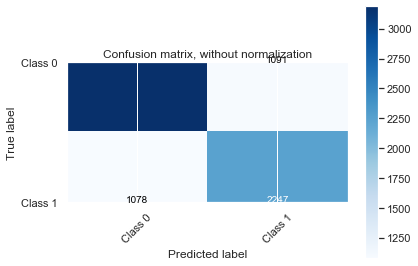

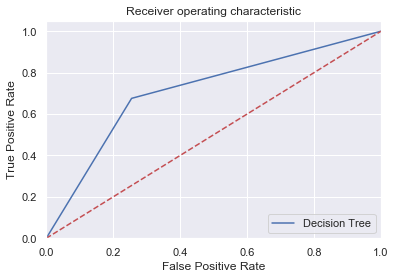

In [20]:
if DT_flag:
    # Decision Tree Model

    DT = DecisionTreeClassifier(random_state=42)
    y_train_pred_DT = cross_val_predict(DT, x_train, y_train, cv=3)
    y_train_pred = y_train_pred_DT
    print("DT Accuracy",accuracy_score(y_train, y_train_pred))
    print("roc score", roc_auc_score(y_train, y_train_pred))
    DT_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(DT_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_DT)
    plot_figure(fpr, tpr, "Decision Tree") 


RF Accuracy 0.7875559063404367
roc score 0.7831837367559652
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4277
           1       0.76      0.75      0.75      3325

    accuracy                           0.79      7602
   macro avg       0.78      0.78      0.78      7602
weighted avg       0.79      0.79      0.79      7602

Confusion matrix, without normalization
[[3499  778]
 [ 837 2488]]


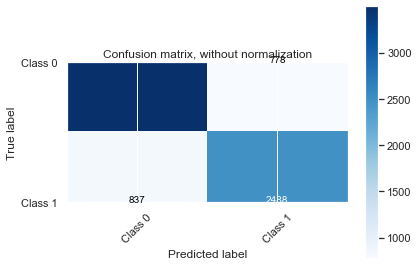

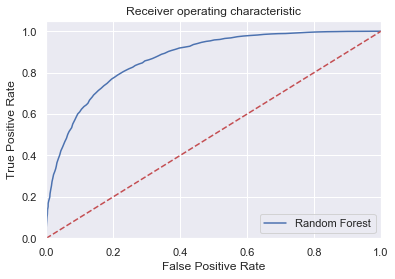

In [21]:
if RF_flag:
    # Ensemble Random Forest Model

    RF = RandomForestClassifier(random_state=42, n_estimators=100)
    y_train_pred_RF = cross_val_predict(RF, x_train, y_train, cv=3, method="predict_proba")[:,1]
    y_train_pred = y_train_pred_RF.round()
    print("RF Accuracy",accuracy_score(y_train, y_train_pred))
    print("roc score", roc_auc_score(y_train, y_train_pred))
    RF_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(RF_CR)
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_RF)
    plot_figure(fpr, tpr, "Random Forest")

GB Accuracy 0.7580899763220206
roc score 0.7520768369368593
Classification Report
              precision    recall  f1-score   support

           0       0.78      0.80      0.79      4277
           1       0.73      0.70      0.72      3325

    accuracy                           0.76      7602
   macro avg       0.75      0.75      0.75      7602
weighted avg       0.76      0.76      0.76      7602

Confusion matrix, without normalization
[[3422  855]
 [ 984 2341]]


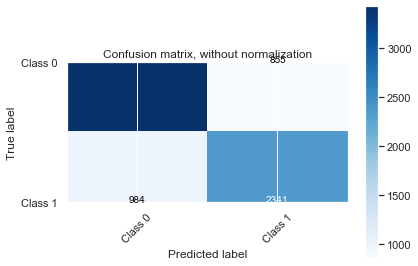

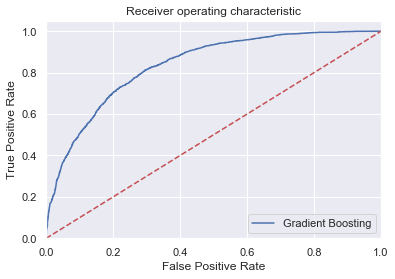

In [22]:
if GB_flag:
    gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5, max_features=2, max_depth=2, random_state=0)
    y_train_pred_gb = cross_val_predict(gb_clf, x_train, y_train, cv=3, method="predict_proba")[:,1]
    y_train_pred = y_train_pred_gb.round()
    print("GB Accuracy",accuracy_score(y_train, y_train_pred))
    roc = roc_auc_score(y_train, y_train_pred)
    print("roc score", roc)
    GB_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(GB_CR)
    
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_gb)
    plot_figure(fpr, tpr, "Gradient Boosting")


NN Accuracy 0.7438831886345698
roc score 0.7385474324108142
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.78      0.77      4277
           1       0.71      0.70      0.70      3325

    accuracy                           0.74      7602
   macro avg       0.74      0.74      0.74      7602
weighted avg       0.74      0.74      0.74      7602

Confusion matrix, without normalization
[[3341  936]
 [1011 2314]]


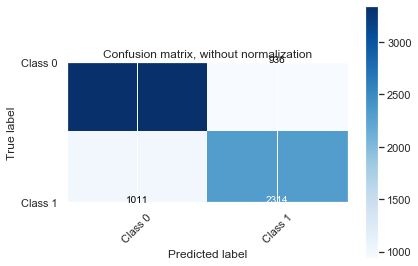

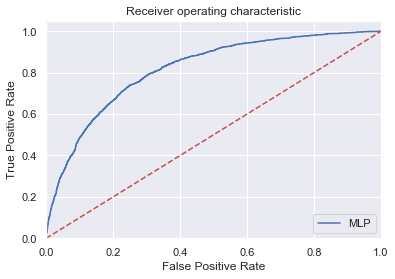

In [23]:
if NN_flag:

    mlp = MLPClassifier(hidden_layer_sizes=(20, 20, 20), max_iter=1000)
    y_train_pred_NN = cross_val_predict(mlp, x_train, y_train, cv=3, method="predict_proba")[:,1]
    y_train_pred = y_train_pred_NN.round()
    print("NN Accuracy",accuracy_score(y_train, y_train_pred))
    print("roc score", roc_auc_score(y_train, y_train_pred))
    NN_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(NN_CR)
    
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                          title='Confusion matrix, without normalization')

    # Compute micro-average ROC curve and ROC area         
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_NN)
    plot_figure(fpr, tpr, "MLP")

GB Accuracy 0.7890028939752697
roc score 0.7850052299324415
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      4277
           1       0.76      0.75      0.76      3325

    accuracy                           0.79      7602
   macro avg       0.79      0.79      0.79      7602
weighted avg       0.79      0.79      0.79      7602

Confusion matrix, without normalization
[[3494  783]
 [ 821 2504]]


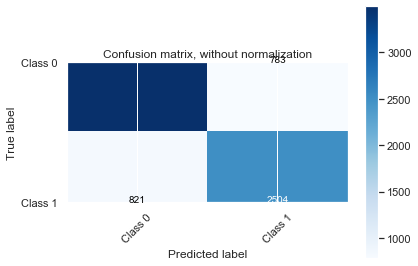

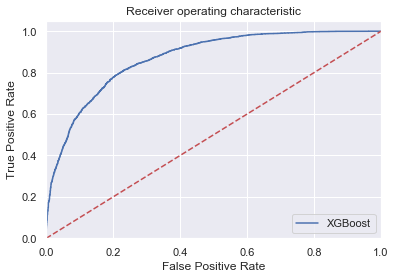

In [24]:
if XGB_flag:   
    xgb = xgboost.XGBClassifier()
    y_train_pred_XGB = cross_val_predict(xgb, x_train, y_train, cv=3, method="predict_proba")[:,1]
    y_train_pred = y_train_pred_XGB.round()
    print("GB Accuracy",accuracy_score(y_train, y_train_pred))
    roc = roc_auc_score(y_train, y_train_pred)
    print("roc score", roc)
    XGB_CR = classification_report(y_train, y_train_pred)
    print("Classification Report")
    print("="*50)
    print(XGB_CR)
    
    # Plot   confusion matrix
    cnf_matrix = confusion_matrix(y_train, y_train_pred)
    np.set_printoptions(precision=2)

    plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                      title='Confusion matrix, without normalization')
    
    # Compute micro-average ROC curve and ROC area 
    fpr, tpr, thresholds = roc_curve(y_train, y_train_pred_XGB)
    plot_figure(fpr, tpr, "XGBoost")


Below will display classification report of respective models.

In [25]:
report_list = [LR_CR,SVM_CR,DT_CR,RF_CR,GB_CR,NN_CR,XGB_CR]
model_list = ['LR','SVM','DT','RF','GB','NN','XGB']
def display_report(model,report):
    display(Markdown(model+" **Model Classification Report** \n"))
    print('\n',report)
    
for (model,report) in zip(model_list, report_list):
    display_report(model,report)
  

LR **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.76      0.82      0.79      4277
           1       0.74      0.68      0.71      3325

    accuracy                           0.76      7602
   macro avg       0.75      0.75      0.75      7602
weighted avg       0.75      0.76      0.75      7602



SVM **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.74      0.70      0.72      4277
           1       0.64      0.69      0.66      3325

    accuracy                           0.69      7602
   macro avg       0.69      0.69      0.69      7602
weighted avg       0.70      0.69      0.69      7602



DT **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.75      0.74      0.75      4277
           1       0.67      0.68      0.67      3325

    accuracy                           0.71      7602
   macro avg       0.71      0.71      0.71      7602
weighted avg       0.71      0.71      0.71      7602



RF **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.81      0.82      0.81      4277
           1       0.76      0.75      0.75      3325

    accuracy                           0.79      7602
   macro avg       0.78      0.78      0.78      7602
weighted avg       0.79      0.79      0.79      7602



GB **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.78      0.80      0.79      4277
           1       0.73      0.70      0.72      3325

    accuracy                           0.76      7602
   macro avg       0.75      0.75      0.75      7602
weighted avg       0.76      0.76      0.76      7602



NN **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.77      0.78      0.77      4277
           1       0.71      0.70      0.70      3325

    accuracy                           0.74      7602
   macro avg       0.74      0.74      0.74      7602
weighted avg       0.74      0.74      0.74      7602



XGB **Model Classification Report** 



               precision    recall  f1-score   support

           0       0.81      0.82      0.81      4277
           1       0.76      0.75      0.76      3325

    accuracy                           0.79      7602
   macro avg       0.79      0.79      0.79      7602
weighted avg       0.79      0.79      0.79      7602



## 6. Evaluating the test data
Based on overall performance on F1-score, we decided to choose XGB model for this classification problem. 

GB Accuracy 0.7951854775059195
roc score 0.7896488084516033
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      1419
           1       0.78      0.74      0.76      1115

    accuracy                           0.80      2534
   macro avg       0.79      0.79      0.79      2534
weighted avg       0.79      0.80      0.79      2534

Confusion matrix, without normalization
[[1186  233]
 [ 286  829]]


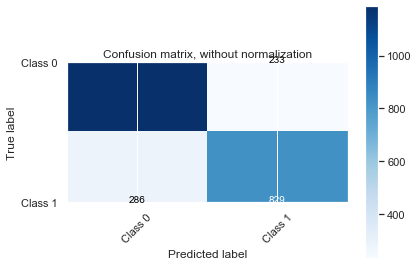

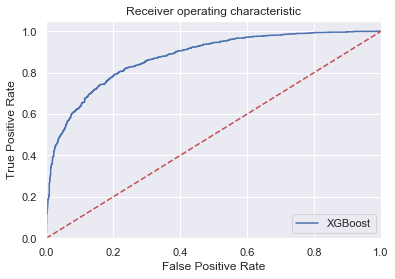

In [34]:
xgb.fit(x_train, y_train)
y_test_pred_xgb = xgb.predict_proba(x_test)[:,1]
y_test_pred = y_test_pred_xgb.round()
print("GB Accuracy",accuracy_score(y_test, y_test_pred))
roc = roc_auc_score(y_test, y_test_pred)
print("roc score", roc)
XGB_CR = classification_report(y_test, y_test_pred)
print("Classification Report")
print("="*50)
print(XGB_CR)

# Plot   confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

plot_confusion_matrix(cnf_matrix, classes=['Class 0', 'Class 1'],
                  title='Confusion matrix, without normalization')

# Compute micro-average ROC curve and ROC area 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_xgb)
plot_figure(fpr, tpr, "XGBoost")